Similar to Experiment 76 but here the list of $\epsilon$s is adaptively chosen based on the distance of the particles, as done in Chang's code. The only thing to be careful about is that in Chang's code he was using a uniform kernel, whereas here are using a normal kernel.

In [553]:
import numpy as np
from numpy.random import rand, randn
from numpy import ones, exp, log, diag, vstack, pi, array, r_, isfinite, logspace, zeros, eye, quantile
from numpy.linalg import norm, solve
from numpy.random import default_rng, choice, randint
from scipy.optimize import fsolve
from scipy.stats import multivariate_normal as MVN
from scipy.special import ndtri, ndtr
from scipy.stats import uniform as udist
from scipy.stats import norm as ndist
from scipy.linalg import block_diag

import time
from math import prod
from warnings import catch_warnings, filterwarnings, resetwarnings


import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import interact


from RWM import RWM
from Manifolds.Manifold import Manifold
from tangential_hug_functions import HugTangentialMultivariate
from utils import ESS_univariate, prep_contour
from copy import deepcopy

# G-and-K Functions and Settings

In [561]:
class GKManifold(Manifold):
    def __init__(self, ystar, kernel_type='normal'):
        assert kernel_type in ['normal', 'uniform']
        self.m = len(ystar)            # Number constraints = dimensionality of the data
        self.d = 4                     # Manifold has dimension 4 (like the parameter θ)
        self.n = self.d + self.m       # Dimension of ambient space is m + 4
        self.ystar = ystar
        self.kernel_type = kernel_type
        # N(0, 1) ---> U(0, 10).
        self.G    = lambda θ: 10*ndtr(θ)
        # U(0, 10) ---> N(0, 1)
        self.Ginv = lambda θ: ndtri(θ/10)

    def q(self, ξ):
        """Constraint for G and K."""
        ξ = r_[self.G(ξ[:4]), ξ[4:]]   # expecting theta part to be N(0, 1)
        with catch_warnings():
            filterwarnings('error')
            try:
                return (ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]) - self.ystar
            except RuntimeWarning:
                raise ValueError("Constraint found Overflow warning.")
                
    def _q_raw_uniform(self, ξ):
        """Constraint function expecting ξ[:4] ~ U(0, 10). It doesn't do any warning check."""
        return (ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]) - self.ystar
    def _q_raw_normal(self, ξ):
        """Same as `_q_raw_uniform` except expects ξ[:4]~N(0,1)."""
        ξ = r_[self.G(ξ[:4]), ξ[4:]] 
        return self._q_raw_uniform(ξ)

    def Q(self, ξ):
        """Transpose of Jacobian for G and K. """
        ξ = r_[self.G(ξ[:4]), ξ[4:]]
        return vstack((
        ones(len(ξ[4:])),
        (1 + 0.8 * (1 - exp(-ξ[2] * ξ[4:])) / (1 + exp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:],
        8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * exp(ξ[2]*ξ[4:]) / (5 * (1 + exp(ξ[2]*ξ[4:]))**2),
        ξ[1]*ξ[4:]*((1+ξ[4:]**2)**ξ[3])*(1 + 9*exp(ξ[2]*ξ[4:]))*log(1 + ξ[4:]**2) / (5*(1 + exp(ξ[2]*ξ[4:]))),
        diag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*exp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*exp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + exp(ξ[2]*ξ[4:]))**2))
    ))
    
    def J(self, ξ):
        """Safely computes Jacobian."""
        with catch_warnings():
            filterwarnings('error')
            try:
                return self.Q(ξ).T
            except RuntimeWarning:
                raise ValueError("J computation found Runtime warning.")
                
    def fullJacobian(self, ξ):
        """J_f(G(ξ)) * J_G(ξ)."""
        JGbar = block_diag(10*np.diag(ndist.pdf(ξ[:4])), eye(len(ξ[4:])))
        return self.J(ξ) @ JGbar
                
    def log_parameter_prior(self, θ):
        """IMPORTANT: Typically the prior distribution is a U(0, 10) for all four parameters.
        We keep the same prior but since we don't want to work on a constrained space, we 
        reparametrize the problem to an unconstrained space N(0, 1)."""
        with catch_warnings():
            filterwarnings('error')
            try:
                return udist.logpdf(self.G(θ), loc=0.0, scale=10.0).sum() + ndist.logpdf(θ).sum()
            except RuntimeWarning:
                return -np.inf
            
    def logprior(self, ξ):
        """Computes the prior distribution for G and K problem. Notice this is already reparametrized."""
        return self.log_parameter_prior(ξ[:4]) - ξ[4:]@ξ[4:]/2

    def logη(self, ξ):
        """log posterior for c-rwm. This is on the manifold."""
        try:
            J = self.J(ξ)
            logprior = self.logprior(ξ)
            correction_term  = - prod(np.linalg.slogdet(J@J.T))/2 
            return  logprior + correction_term
        except ValueError as e:
            return -np.inf
        
    def generate_logηϵ(self, ϵ):
        """Returns the log abc posterior for THUG."""
        if self.kernel_type not in ['normal', 'uniform']:
            raise NotImplementedError
        else:
            if self.kernel_type == 'normal':
                def log_abc_posterior(ξ):
                    """Log-ABC-posterior."""
                    u = self.q(ξ)
                    m = len(u)
                    return self.logprior(ξ) - u@u/(2*ϵ**2) - m*log(ϵ) - m*log(2*pi)/2
                return log_abc_posterior
            else:
                # uniform kernel
                def log_abc_posterior(ξ):
                    with np.errstate(divide='ignore'):
                        return log(float(norm(self.q(ξ)) <= ϵ) / ϵ)
                return log_abc_posterior
            
    def logp(self, v):
        """Log density for normal on the tangent space."""
        return MVN(mean=zeros(self.d), cov=eye(self.d)).logpdf(v)
    
    def is_on_manifold(self, ξ, tol=1e-8):
        """Checks if ξ is on the ystar manifold."""
        return np.max(abs(self.q(ξ))) < tol
    
    
"""
OTHER FUNCTIONS
"""    
def generate_powers_of_ten(max_exponent, min_exponent):
    """E.g. generate_powers_of_ten(2, -1) will return 100, 10, 0, 0.1."""
    number_of_powers = max_exponent + abs(min_exponent) + 1
    return logspace(start=max_exponent, stop=min_exponent, num=number_of_powers, endpoint=True)


def data_generator(θ0, m, seed):
    """Stochastic Simulator. Generates y given θ."""
    rng = default_rng(seed)
    z = rng.normal(size=m)
    ξ = r_[θ0, z]
    return ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]

def find_point_on_manifold(ystar, ϵ, max_iter=1000, tol=1.49012e-08, kernel_type='normal'):
    """Find a point on the data manifold."""
    i = 0
    manifold = GKManifold(ystar=ystar, kernel_type=kernel_type)
    log_abc_posterior = manifold.generate_logηϵ(ϵ)
    with catch_warnings():
        filterwarnings('error')
        while i <= max_iter:
            i += 1
            try: 
                # Sample θ from U(0, 10)
                θfixed = randn(4)
                function = lambda z: manifold._q_raw_normal(r_[θfixed, z])
                z_guess  = randn(manifold.m)
                z_found  = fsolve(function, z_guess, xtol=tol)
                ξ_found  = r_[θfixed, z_found]
                if not isfinite([log_abc_posterior(ξ_found)]):
                    pass
                else:
                    resetwarnings()
                    return ξ_found

            except RuntimeWarning:
                continue
        resetwarnings()
        raise ValueError("Couldn't find a point, try again.") 
        
        
def find_point_on_manifold_from_θ(ystar, θfixed, ϵ, maxiter=2000, tol=1.49012e-08, kernel_type='normal'):
    """Same as the above but we provide the θfixed. Can be used to find a point where
    the theta is already θ0."""
    i = 0
    manifold = GKManifold(ystar=ystar, kernel_type=kernel_type)
    log_abc_posterior = manifold.generate_logηϵ(ϵ)
    function = lambda z: manifold._q_raw_normal(r_[θfixed, z])
    with catch_warnings():
        filterwarnings('error')
        while i <= maxiter:
            i += 1
            try:
                z_guess  = randn(manifold.m)
                z_found  = fsolve(function, z_guess, xtol=tol)
                ξ_found  = r_[θfixed, z_found]
                if not isfinite([log_abc_posterior(ξ_found)]):
                    resetwarnings()
                    raise ValueError("Couldn't find a point.")
                else:
                    resetwarnings()
                    return ξ_found
            except RuntimeWarning:
                continue
        resetwarnings()
        raise ValueError("Couldn't find a point, try again.")



In [605]:
def generate_setting(m, B, δ, N, quantile_value, ϵ_min, ϵ0, maxiter, thinning=10, kernel_type='normal', δ0=None):
    """Generates an object from which one can grab the settings. This allows one to run multiple scenarios."""
    θ0        = array([3.0, 1.0, 2.0, 0.5])      # True parameter value on U(0, 10) scale.
    d         = 4 + m                            # Dimensionality of ξ=(θ, z)
    ystar     = data_generator(θ0, m, seed=1234) # Observed data
    q         = MVN(zeros(d), eye(d))            # Proposal distribution for THUG
    ξ0        = find_point_on_manifold_from_θ(ystar=ystar, θfixed=ndtri(θ0/10), ϵ=1e-5, maxiter=5000, tol=1e-15, kernel_type=kernel_type)
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel_type)
    if δ0 is None:
        δ0 = δ
    return {
        'θ0': θ0,
        'm' : m,
        'd' : d,
        'ystar': ystar,
        'q': q,
        'ξ0': ξ0,
        'B': B,
        'δ': δ,
        'N': N,
        'manifold': manifold,
        'thinning': thinning,
        'quantile_value': quantile_value,
        'ϵ_min': ϵ_min,
        'ϵ0': ϵ0,
        'maxiter': maxiter,
        'kernel_type': kernel_type,
        'δ0': δ0
    }

# Multivariate Markov Snippets

In [556]:
def linear_project(v, J):
    """Projects by solving linear system."""
    return J.T.dot(solve(J.dot(J.T), J.dot(v)))

def THUGIntegratorMultivariate(z0, B, δ):
    """THUG Integrator for the 2D example (ie using gradients, not jacobians)."""
    trajectory = zeros((B + 1, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    trajectory[0, :] = z0
    # Integrate
    for b in range(B):
        x = x + δ*v/2
        v = v - 2*linear_project(v, SETTINGS50['manifold'].fullJacobian(x))
        x = x + δ*v/2
        trajectory[b+1, :] = np.hstack((x, v))
    return trajectory

def generate_THUGIntegratorMultivariate(B, δ):
    """Returns a THUG integrator for a given B and δ."""
    integrator = lambda z: THUGIntegratorMultivariate(z, B, δ)
    return integrator

#### Random Walk Integrator
def RWMIntegrator(z0, B, δ):
    """Basically returns B+1 points on the line starting at x0 with direction v0."""
    trajectory = zeros((B+1, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    bs  = np.arange(B+1).reshape(-1, 1) # 0, 1, ..., B
    xbs = x0 + δ*bs*v0     # move them by b*δ
    vbs = np.repeat(v0.reshape(1, -1), repeats=B+1, axis=0)
    zbs = np.hstack((xbs, vbs))
    return zbs

def generate_RWMIntegrator(B, δ):
    """Generates the integrator above."""
    integrator = lambda z: RWMIntegrator(z, B, δ)
    return integrator


#### Metropolis-Hastings version for SMC version
def THUG_MH(z0, B, δ, logpi):
    """Similar to THUGIntegratoUnivariateOnlyEnd but this uses a MH step."""
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    logu = np.log(np.random.rand())
    for _ in range(B):
        x = x + δ*v/2
        v = v - 2*linear_project(v, SETTINGS50['manifold'].fullJacobian(x))
        x = x + δ*v/2
    if logu <= logpi(x) - logpi(x0):
        # accept new point
        return np.concatenate((x, v))
    else:
        # accept old point
        return z0

In [606]:
class MultivariateMarkovSnippetsTHUG:
    
    def __init__(self, SETTINGS, force_rwm=True):
        """Multivariate Markov Snippets SMC samplers corresponding exactly to Algorithm 1 in Christophe's notes.
        It uses the Multivariate THUG kernel as its mutation kernel. The sequence of distributions is fixed here 
        since we provide ϵs, i.e. a list of tolerances which automatically fully specify the posterior 
        distributions used at each round.
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        """
        # Input variables
        self.N  = SETTINGS['N']       
        self.B  = SETTINGS['B']
        self.δ  = SETTINGS['δ']
        self.δ0 = SETTINGS['δ0']
        self.d  = SETTINGS['d']
        self.manifold = SETTINGS['manifold']
        self.SETTINGS = SETTINGS
        self.quantile_value = SETTINGS['quantile_value']
        self.ϵ_min = SETTINGS['ϵ_min']
        self.ϵs     = []
        self.log_ηs = []
        self.maxiter = SETTINGS['maxiter']
        
        # Variables derived from the above
        if not force_rwm:
            self.ψ = generate_THUGIntegratorMultivariate(self.B, self.δ)
        else:
            self.ψ = generate_RWMIntegrator(self.B, self.δ)
            
        # choose function to compute distances
        if self.manifold.kernel_type == 'uniform':
            # distance function is linear in ||f(x) - y||
            self.compute_distances = lambda XNK: norm(np.apply_along_axis(self.manifold.q, 1, XNK), axis=1)
        elif self.manifold.kernel_type == 'normal':
            # distance function is quadratic in ||f(x) - y||
            self.compute_distances = lambda XNK: norm(np.apply_along_axis(self.manifold.q, 1, XNK), axis=1)**2
        else:
            raise ValueError("Manifold has an unexpected kernel type.")
    
    def initialize_particles(self):
        """There's three strategies:
        
        1. Start with ϵ0=infinity and sample from the prior using RWM.
        2. Start with ϵ0=infinity ans sample from the prior using THUG.
        3. Start with large but finite ϵ0 and sample from ηϵ0 with THUG.
        4. Start with large but finite ϵ0 and samlpe from ηϵ0 with RWM.
        
        Here we use strategy 4.
        """
        # Initialize first position on the manifold
        x0 = self.SETTINGS['ξ0']
        # Grab ϵ0
        ϵ0 = self.SETTINGS['ϵ0']
        log_ηϵ0 = self.manifold.generate_logηϵ(ϵ0)
#         ϵ0 = np.inf
        self.ϵs.append(ϵ0)
#         log_ηϵ0 = self.manifold.logprior
        self.log_ηs.append(log_ηϵ0)
        # Sample using RWM
        burn_in = 100
        thinning = 10
        ### try initializing using Tangential Hug as MCMC kernel?
        TO_BE_THINNED, acceptance = RWM(x0, self.δ0, burn_in + thinning*self.N, log_ηϵ0)
#         q = MVN(zeros(self.d), eye(self.d))
#         TO_BE_THINNED, acceptance = HugTangentialMultivariate(x0, self.B*self.δ, self.B, burn_in + thinning*self.N, 0.0, q, log_ηϵ0, self.manifold.fullJacobian, method='linear')
        print("Initializing particles. Acceptance: ", np.mean(acceptance)*100)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::thinning]
        # Refresh velocities and form particles
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self, manual_initialization=False, z_starting=None):
        """Starts the Markov Snippets sampler."""
        if manual_initialization and (z_starting is None):
            raise ValueError("If manual initialization, must provide z.")
        
        starting_time = time.time() 
        N = self.N
        B = self.B
        
        # Initialize particles
        if not manual_initialization:
            z = self.initialize_particles()   # (N, 2d)
        else:
            z = z_starting
        
        ## Storage
        #### Store z_n^{(i)}
#         self.ZN  = np.zeros((N, 2*self.d))  #np.zeros((self.P+1, N, 2*self.d))
        #### Store z_{n, k}^{(i)} so basically all the N(T+1) particles
        self.ZNK  = zeros((1, N*(B+1), 2*self.d)) #np.zeros((self.P, N*(B+1), 2*self.d))
        self.Wbar = zeros((1, N*(B+1)))
        self.DISTANCES = zeros(N*(B+1))
        self.ESS  = [N]
        self.K_RESAMPLED = zeros((1, self.N))
        
        self.ZN = z
        # For each target distribution, run the following loop
        n = 1 # counts the iteration number, basically equivalent to n before
        while n <= self.maxiter:
            try:
                print("Iteration: ", n)
                
                ##### RECONSTRUCT PATHS
                Z = np.apply_along_axis(self.ψ, 1, z)
                self.ZNK = np.vstack((self.ZNK, Z.reshape(1, N*(B+1), 2*self.d)))
                
                ##### ADAPTIVELY CHOOSE ϵ (choose it based on ALL particles, not just the starting points)
                ## Compute distances ||f(x)-y|| for all particles
                distances = norm(np.apply_along_axis(self.manifold.q, 1, self.ZNK[-1, :, :self.d]), axis=1)
                self.DISTANCES = np.vstack((self.DISTANCES, distances))
                ## Find ϵ based on quantile value and store it
                ϵ = max(self.ϵ_min, min(self.ϵs[-1], quantile(np.unique(distances), self.quantile_value)))
                print("\tEpsilon: ", ϵ)
                self.ϵs.append(ϵ)
                # Use ϵ to construct the target distribution
                self.log_ηs.append(self.manifold.generate_logηϵ(ϵ))

                ##### COMPUTE WEIGHTS
                # Log-Denominator: shared for each point in the same trajectory
                log_μnm1_z  = np.apply_along_axis(self.log_ηs[-2], 1, Z[:, 0, :self.d])  # (N, )
                log_μnm1_z  = np.repeat(log_μnm1_z, self.B+1, axis=0).reshape(N, B+1)     # (N, B+1)
                # Log-Numerator: different for each point on a trajectory.
                log_μn_ψk_z = np.apply_along_axis(self.log_ηs[-1], 2, Z[:, :, :self.d])    # (N, B+1)
                # Compute weights, normalize and store
                W = exp(log_μn_ψk_z - log_μnm1_z)
                W = W / W.sum()
                self.Wbar = np.vstack((self.Wbar, W.flatten()))

                ##### COMPUTE ESS
                self.ESS.append(1 / np.sum(W**2))

                ##### RESAMPLE PARTICLES
                resampling_indeces = choice(a=np.arange(N*(B+1)), size=N, p=W.flatten())
                unravelled_indeces = np.unravel_index(resampling_indeces, (N, B+1))
                self.K_RESAMPLED = np.vstack((self.K_RESAMPLED, unravelled_indeces[1]))
                indeces = np.dstack(unravelled_indeces).squeeze()
                z = np.vstack([Z[tuple(ix)] for ix in indeces])     # (N, 2d)

                ##### REJUVENATE VELOCITIES
                z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(N, self.d))
                self.ZN = np.vstack((self.ZN, z))
            except (ValueError, RuntimeError, KeyboardInterrupt) as e:
                print("EXITING: ", e)
                self.total_time = time.time() - starting_time
                return z
            n += 1
                
        self.total_time = time.time() - starting_time
        return z

In [627]:
SETTINGS50 = generate_setting(
    m=50, ϵ0=10, B=50, δ=0.01, N=5000, quantile_value=0.01, 
    ϵ_min=0.00001, maxiter=100, δ0=0.1, thinning=10, kernel_type='uniform')

In [628]:
# I need to make sure all the storing arrays have the desired shapes. 
# I also need to check that I am computing the distances correctly on ZNK because this array has 3 dimensions.

In [629]:
# Instantitate the algorithm
MSTHUG = MultivariateMarkovSnippetsTHUG(SETTINGS50)

In [630]:
# # Initialize particles
# z_starting = MSTHUG.initialize_particles()

In [ ]:
# Sample
# zP = MSTHUG.sample(manual_initialization=True, z_starting=z_starting)
zP = MSTHUG.sample(manual_initialization=False)

Initializing particles. Acceptance:  1.12375249500998
Iteration:  1
	Epsilon:  9.22831937633956
Iteration:  2
	Epsilon:  8.489668313140577
Iteration:  3
	Epsilon:  7.714048538667064
Iteration:  4
	Epsilon:  7.102604853851798
Iteration:  5
	Epsilon:  6.727775745617697
Iteration:  6
	Epsilon:  6.466810560650521
Iteration:  7
	Epsilon:  6.232415378802041
Iteration:  8
	Epsilon:  6.035132677666011
Iteration:  9
	Epsilon:  5.8427598872785405
Iteration:  10
	Epsilon:  5.754133367612003
Iteration:  11
	Epsilon:  5.683695173824842
Iteration:  12
	Epsilon:  5.616355646823517
Iteration:  13
	Epsilon:  5.552563760092189
Iteration:  14
	Epsilon:  5.509856871248804
Iteration:  15
	Epsilon:  5.474991808710802
Iteration:  16
	Epsilon:  5.434881761810904
Iteration:  17
	Epsilon:  5.390034262236231
Iteration:  18
	Epsilon:  5.348785037705181
Iteration:  19
	Epsilon:  5.316411027890311
Iteration:  20
	Epsilon:  5.28566414191328
Iteration:  21
	Epsilon:  5.256812314765944
Iteration:  22
	Epsilon:  5.2363

In [ ]:
def plot_histogram(n):
    fig, ax = plt.subplots(figsize=(20, 4))
    bins        = np.arange(-0.5, SETTINGS50['B']+0.5, step=1.0)
    bins_labels = np.arange(SETTINGS50['B'])
    _ = ax.hist(MSTHUG.K_RESAMPLED[n, :], density=True, bins=bins, edgecolor='k', color='lightsalmon')
    ax.set_xticks(bins_labels)
    ax.set_xticklabels(bins_labels)
    plt.show()

resetwarnings()
interact(plot_histogram, n=(0, len(MSTHUG.ϵs) - 2))

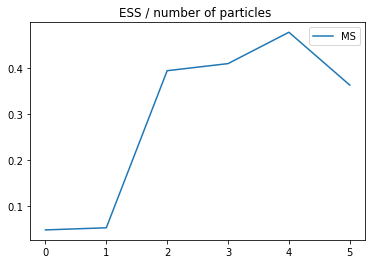

In [200]:
fig, ax = plt.subplots()
ax.plot(np.array(MSTHUG.ESS) / (MSTHUG.N*(MSTHUG.B+1)), label='MS')
ax.legend()
ax.set_title("ESS / number of particles ")
plt.show()

In [201]:
for i in range(MSTHUG.DISTANCES.shape[0]):
    print(quantile(MSTHUG.DISTANCES[i], q=[0.01, 0.25, 0.5, 0.75, 0.99]))

[0. 0. 0. 0. 0.]
[17.58213012 20.61121852 22.47168475 25.24191706 34.74893682]
[19.16127602 23.3813125  27.70171234 34.0614185  44.89356184]
[19.30348908 23.65835261 28.26032658 34.65761984 44.89377525]
[19.40273607 23.82784687 28.09382546 34.61802481 44.89351066]
[19.11137894 23.70617999 28.18000191 34.63685107 44.89019833]


### RWM verision

In [607]:
SETTINGS50_rwm = generate_setting(
    m=50, ϵ0=100, B=50, δ=0.001, N=5000, quantile_value=0.01, 
    ϵ_min=0.00001, maxiter=30, thinning=10, kernel_type='normal',
    δ0 = 0.1
)

In [608]:
MSRWM = MultivariateMarkovSnippetsTHUG(SETTINGS50_rwm, force_rwm=True)

In [609]:
# Why is the schedule not decreasing even for RWM? Could it be that because we are using a gaussian kernel
# this strategy makes little sense? 
# Remember: particles are chosen based on their weights, which depend both on the prior density and on the kernel
# which in this case is Gaussian. They are NOT chosen based on their distance, although this plays a role
# through the kernel.

In [610]:
# Sample
zP_rwm = MSRWM.sample(manual_initialization=False)

Initializing particles. Acceptance:  21.269461077844312
Iteration:  1
	Epsilon:  20.32787924307508
Iteration:  2
	Epsilon:  19.304184141086324
Iteration:  3
	Epsilon:  19.148477729764128
Iteration:  4
	Epsilon:  18.997707594031613
Iteration:  5
	Epsilon:  18.875985034248604
Iteration:  6
	Epsilon:  18.725407026137656
Iteration:  7
	Epsilon:  18.725407026137656
Iteration:  8
	Epsilon:  18.725407026137656
Iteration:  9
	Epsilon:  18.725407026137656
Iteration:  10
	Epsilon:  18.725407026137656
Iteration:  11
	Epsilon:  18.725407026137656
Iteration:  12
	Epsilon:  18.725407026137656
Iteration:  13
	Epsilon:  18.725407026137656
Iteration:  14
EXITING:  


In [600]:
def plot_histogram_rwm(n):
    fig, ax = plt.subplots(figsize=(20, 4))
    bins        = np.arange(-0.5, SETTINGS50_rwm['B']+0.5, step=1.0)
    bins_labels = np.arange(SETTINGS50_rwm['B'])
    _ = ax.hist(MSRWM.K_RESAMPLED[n, :], density=True, bins=bins, edgecolor='k', color='lightsalmon')
    ax.set_xticks(bins_labels)
    ax.set_xticklabels(bins_labels)
    plt.show()

resetwarnings()
interact(plot_histogram_rwm, n=(0, len(MSRWM.ϵs) - 2))

interactive(children=(IntSlider(value=14, description='n', max=29), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_histogram_rwm(n)>

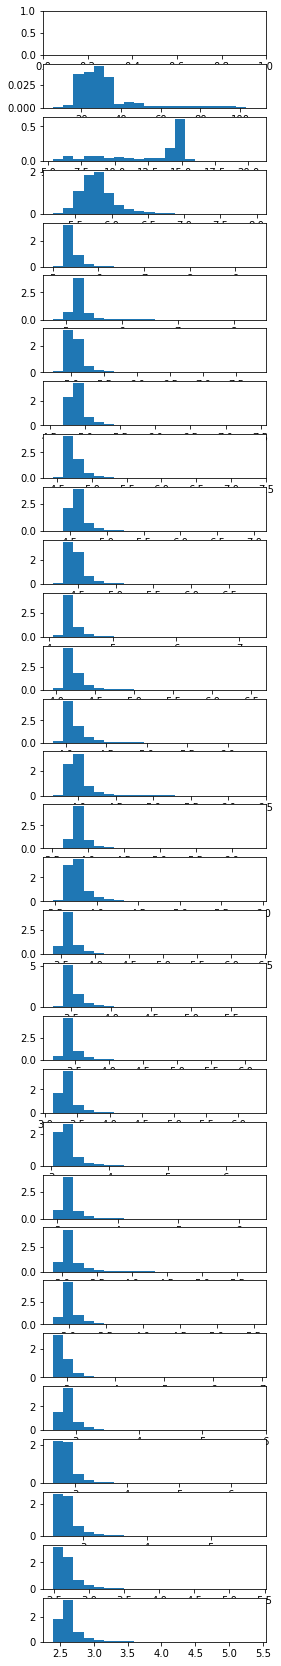

In [601]:
fig, ax = plt.subplots(nrows=MSRWM.DISTANCES.shape[0], figsize=(4, 30))
for i in range(1, MSRWM.DISTANCES.shape[0]):
    _ = ax[i].hist(MSRWM.DISTANCES[i], bins=MSRWM.B, density=True)

#### Distribution of distances of initial particles

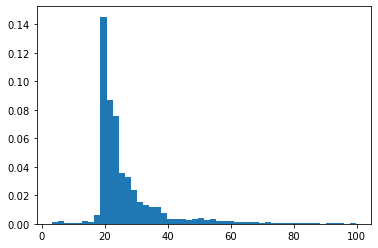

In [578]:
_ = plt.hist(norm(np.apply_along_axis(MSRWM.manifold.q, 1, MSRWM.starting_particles[:, :MSRWM.d]), axis=1), bins=MSRWM.B, density=True)

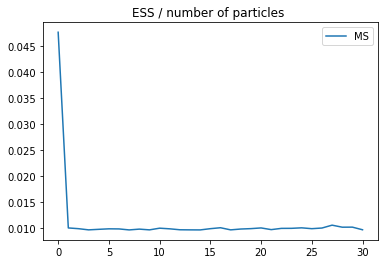

In [602]:
fig, ax = plt.subplots()
ax.plot(np.array(MSRWM.ESS) / (MSRWM.N*(MSRWM.B+1)), label='MS')
ax.legend()
ax.set_title("ESS / number of particles ")
plt.show()